# Import necessary libraries

In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
from shapely.geometry import Point

import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import requests
import json
from tqdm import tqdm

import requests
import json

# Part 1

In Part 1, we processed geodetic data to create a shapefile (instruments.shp) with the geographic positions of instruments. The data was merged, transformed to EPSG:4326, structured with site_id and instrument_id, and cleaned for GIS integration.

In [2]:
# Step 1: Load the files into pandas DataFrames
doris_df = pd.read_fwf('ITRF2020_DORIS_cart.txt')
gnss_df = pd.read_fwf('ITRF2020_GNSS_cart.txt')
slr_df = pd.read_fwf('ITRF2020_SLR_cart.txt')
vlbi_df = pd.read_fwf('ITRF2020_VLBI_cart.txt')

In [3]:
# Step 2: Merge all the DataFrames into a single DataFrame
# Combine the data from all the files into one DataFrame for further processing
df_merged = pd.concat([doris_df, gnss_df, slr_df, vlbi_df])
df_merged.head()

In [15]:
# Step 3: Convert to a GeoDataFrame
# Transform coordinates from EPSG:4978 (x, y, z) to EPSG:4326 (latitude, longitude)

# Initialize the transformer for EPSG:4978 to EPSG:4326
transformer = Transformer.from_crs("EPSG:4978", "EPSG:4326", always_xy=True)

# Function to transform x, y, z coordinates to a latitude-longitude point
def convert_to_latlon(row):
    lon, lat, _ = transformer.transform(row['x'], row['y'], row['z'])
    return Point(lon, lat)

# Apply the transformation to create a geometry column
df_merged['geometry'] = df_merged.apply(convert_to_latlon, axis=1)

# Convert the DataFrame into a GeoDataFrame with EPSG:4326 as its CRS
gdf = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")
gdf.head()

,id,name,type,code,x,y,z,dx,dy,dz,geometry
0,10002S018,Grasse (OCA),DORIS,GR3B,4.581680e+06,556166.4818,4.389372e+06,0.002,0.0025,0.002,POINT (6.92123 43.75483)
1,10002S019,Grasse (OCA),DORIS,GR4B,4.581681e+06,556166.9141,4.389371e+06,0.0019,0.0024,0.0017,POINT (6.92123 43.75483)
2,10003S001,Toulouse,DORIS,TLSA,4.628047e+06,119670.6873,4.372788e+06,0.0054,0.0062,0.0051,POINT (1.48121 43.55814)
3,10003S003,Toulouse,DORIS,TLHA,4.628693e+06,119985.0770,4.372105e+06,0.0034,0.0042,0.0032,POINT (1.48489 43.54962)
4,10003S005,Toulouse,DORIS,TLSB,4.628694e+06,119985.0787,4.372105e+06,0.0026,0.0039,0.0025,POINT (1.48489 43.54962)


In [4]:
# Step 4: Add site_id and instrument_id columns
# Extract the first 5 characters of 'id' to create the site_id
gdf['site_id'] = gdf['id'].str[:5]  # Site ID is the first 5 characters of the ID
gdf['instrument_id'] = gdf['id']    # Full ID represents the instrument

In [5]:
# Step 5: Remove unnecessary columns
# Keep only the relevant columns for further analysis and save space
columns_to_keep = ['site_id', 'instrument_id', 'type', 'geometry']
gdf_cleaned = gdf[columns_to_keep]

In [6]:
# Step 6: Save the GeoDataFrame to a shapefile
# Output path for the shapefile
output_path = "instruments.shp"

# Save the cleaned GeoDataFrame as a shapefile
gdf_cleaned.to_file(output_path)

print(f"Shapefile saved at: {output_path}")

Shapefile saved at: instruments.shp


<ipython-input-6-e165c005a981>:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_cleaned.to_file(output_path)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'instrument_id' to 'instrument'
  ogr_write(


# Part 2
In Part 2, we identified valid sites with at least 3 instruments from 2 techniques, grouped their points by site, created polygons using convex hulls, and saved the results as `sites.shp`.

In [7]:
# Step 2.1: Filter instruments belonging to valid sites
# A valid site must have at least 3 instruments from 2 different measurement techniques

# Count the number of instruments and techniques per site
site_groups = gdf_cleaned.groupby('site_id').agg(
    instrument_count=('instrument_id', 'count'),
    technique_count=('type', 'nunique')  # Count unique measurement techniques
).reset_index()

# Filter sites with at least 3 instruments and 2 different techniques
valid_sites = site_groups[(site_groups['instrument_count'] >= 3) &
                          (site_groups['technique_count'] >= 2)]['site_id']

# Keep only instruments belonging to valid sites
valid_instruments = gdf_cleaned[gdf_cleaned['site_id'].isin(valid_sites)]

In [8]:
# Step 2.2: Spatial groupby (dissolve) to join points by site
# Dissolve all instrument points belonging to the same site into a single geometry
grouped_sites = valid_instruments.dissolve(by='site_id', as_index=False)

In [9]:
# Step 2.3: Calculate polygons using convex hull
# Generate a convex hull polygon for each site
grouped_sites['geometry'] = grouped_sites['geometry'].convex_hull

# Step 2.4: Save the data
# Save the new GeoDataFrame with the site polygons to a shapefile
output_path_sites = "sites.shp"
grouped_sites.to_file(output_path_sites)

print(f"Shapefile for sites saved at: {output_path_sites}")

Shapefile for sites saved at: sites.shp


<ipython-input-9-d074c2e20823>:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grouped_sites.to_file(output_path_sites)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'instrument_id' to 'instrument'
  ogr_write(


# Part 3

In Part 3, we automated the retrieval of satellite imagery metadata using the Copernicus OpenSearch API, filtering by site extent and date range. The data was parsed, handled for missing fields, and consolidated into a GeoDataFrame, enabling seamless integration into the GIS project for further analysis.

In [10]:
def request_images(wkt_geometry, site_id, output_dir):
    """Query Sentinel API for images covering a site's extent."""
    items = []
    page = 1  # Pagination support
    while True:
        # API request
        r = requests.get(
            "https://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel2/search.json",
            params={
                "geometry": wkt_geometry,
                "startDate": "2022-01-01T00:00:00.000Z",
                "completionDate": "2022-09-30T23:59:59.999Z",
                "cloudCover": "[0,10]",
                "maxRecords": 20,
                "page": page,
            }
        )
        # Check response
        if r.status_code != 200:
            print(f"Error querying API for site {site_id}: {r.status_code}")
            break

        data = r.json()
        if 'features' in data:
            items.extend(data['features'])

        # Stop if no more pages
        if len(data['features']) < 20:
            break
        page += 1

    # Save results to JSON file
    json_file = f"{output_dir}/{site_id}.json"
    with open(json_file, 'w') as f:
        json.dump(items, f, indent=4)

    return items

In [11]:
from shapely.geometry import shape

# Paths
output_dir = "site_json_data"
os.makedirs(output_dir, exist_ok=True)

# Load sites GeoDataFrame from Part 2
sites_gdf = gpd.read_file("sites.shp")

# Step 3.1: Query images for each site
image_data = []

for _, row in tqdm(sites_gdf.iterrows(), total=sites_gdf.shape[0]):
    site_id = row['site_id']
    polygon = row['geometry'].wkt  # Get the WKT representation of the polygon

    # Check if JSON exists
    json_file = os.path.join(output_dir, f"{site_id}.json")
    if os.path.exists(json_file):
        # Load existing JSON
        with open(json_file, 'r') as f:
            items = json.load(f)
    else:
        # Query the API
        items = request_images(polygon, site_id, output_dir)

    # Parse and collect image data
    for item in items:
        properties = item.get('properties', {})
        geometry = item.get('geometry', {})

        image_data.append({
            "site_id": site_id,
            "id": properties.get('id', 'N/A'),  # Use 'N/A' if 'id' is missing
            "title": properties.get('title', 'N/A'),
            "thumbnail": properties.get('quicklook', 'N/A'),
            "url": properties.get('services', {}).get('download', {}).get('url', 'N/A'),
            "orbitNumber": properties.get('orbitNumber', 'N/A'),
            "ron": properties.get('relativeOrbitNumber', 'N/A'),
            "orbit": properties.get('orbitDirection', 'N/A'),
            "platform": properties.get('platform', 'N/A'),
            "geometry": shape(geometry) if geometry else None
        })


100%|██████████| 105/105 [29:05<00:00, 16.62s/it]


In [12]:
# Step 3.2: Create GeoDataFrame for images
df_images = pd.DataFrame(image_data)
gdf_images = gpd.GeoDataFrame(
    df_images,
    geometry=gpd.GeoSeries(df_images['geometry']),
    crs="EPSG:4326"
)

In [13]:
# Step 3.3: Save the data
output_path_images = "images.shp"
gdf_images.to_file(output_path_images)
print(f"Shapefile for images saved at: {output_path_images}")

<ipython-input-13-91bd1d113bc4>:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_images.to_file(output_path_images)
/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'orbitNumber' to 'orbitNumbe'
  ogr_write(


Shapefile for images saved at: images.shp


<ipython-input-14-bd9efdc3ba66>:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', fontsize=12)


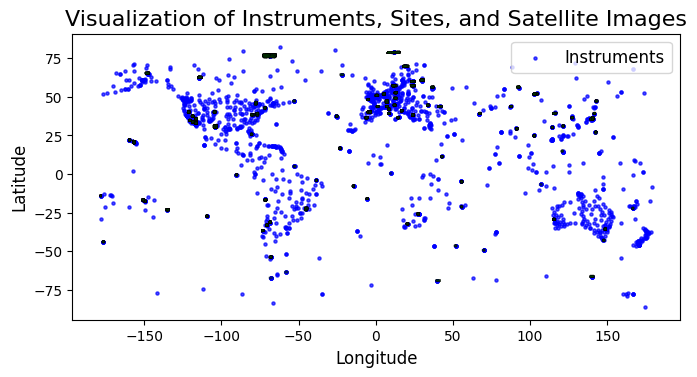

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the SHP files
instruments_gdf = gpd.read_file('instruments.shp')  # Replace with your SHP file path
sites_gdf = gpd.read_file('sites.shp')  # Replace with your SHP file path
images_gdf = gpd.read_file('images.shp')  # Replace with your SHP file path

# Set up a better plot layout and zoomed-in view
fig, ax = plt.subplots(figsize=(7, 4))

# Plot each GeoDataFrame with more distinct visual styles
instruments_gdf.plot(ax=ax, color='blue', marker='o', label='Instruments', markersize=5, alpha=0.7)
sites_gdf.plot(ax=ax, color='red', alpha=0.3, edgecolor='black', label='Sites', linewidth=2)
images_gdf.plot(ax=ax, color='green', alpha=0.2, edgecolor='black', label='Satellite Images', linewidth=1)

# Set plot title and labels
ax.set_title('Visualization of Instruments, Sites, and Satellite Images', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Set a more appropriate aspect ratio
ax.set_aspect('equal', adjustable='box')

# Add a legend
ax.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()